In [1]:
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import os
import pickle
import pandas as pd
from sklearn.utils import resample
from Functions import clean_split


pd.options.display.max_rows = 35 
pd.options.display.max_columns = None

In [2]:


df = pd.read_csv('data/TweetsOriginal.csv', encoding = 'ISO-8859-1')
x_train, x_test, y_train, y_test = clean_split(2, df)
print(x_train.shape, x_test.shape) 
print(y_train.shape, y_test.shape)

Original Value Counts
1.0    2978
0.0     570
Name: Emotion_New, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Final Resampled Value Counts
1.0    600
0.0    570
Name: Emotion_New, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Finished Pickling
(994, 6000) (176, 6000)
(994,) (176,)


In [3]:
log = LogisticRegression()
log.fit(x_train, y_train) 

print(f'Vanilla Train: {log.score(x_train, y_train)}')
print(f'Vanilla Test: {log.score(x_test, y_test)}')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')



ridge = RidgeClassifier(random_state = 10)
ridge.fit(x_train, y_train) 

print(f'Vanilla Train: {ridge.score(x_train, y_train)}')
print(f'Vanilla Test: {ridge.score(x_test, y_test)}')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')


rf = RandomForestClassifier(random_state = 10, n_jobs = -1)
rf.fit(x_train, y_train) 

print(f'Vanilla Train: {rf.score(x_train, y_train)}')
print(f'Vanilla Test: {rf.score(x_test, y_test)}')

Vanilla Train: 0.9859154929577465
Vanilla Test: 0.8181818181818182
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Vanilla Train: 0.9959758551307847
Vanilla Test: 0.8125
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Vanilla Train: 0.9959758551307847
Vanilla Test: 0.8011363636363636


### Resampling
- 0 = negative
- 1 = Positive 
- 2 = neutral

In [4]:
models = {'Log': LogisticRegression(), 'Knn': KNeighborsClassifier(), 
          'DT': DecisionTreeClassifier(random_state = 10), 'Gaussian': GaussianNB(), 'LDA': LinearDiscriminantAnalysis(),
          'LinearSVC': LinearSVC(max_iter = 1250, random_state = 10), 'SDGSVC': SGDClassifier(random_state = 10),  
          'ADA': AdaBoostClassifier(random_state = 10), 'Bagging': BaggingClassifier(random_state = 10), 
          'Ridge': RidgeClassifier(random_state = 10), 
          'RF': RandomForestClassifier(random_state = 10)}

#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 3)
models['stacked'] = stack_model

#test each model and stacking
results = []
model_names = []
pbar = tqdm(models.items())
for model, m in pbar: 
    pbar.set_description(f'Evaluating {model.upper()}')
    cv = RepeatedStratifiedKFold(n_splits = 7, n_repeats = 7)
    scores = cross_val_score(m, x_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = 14, 
                             error_score = 'raise')
    results.append(scores)
    model_names.append(model)

Evaluating STACKED: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [15:56<00:00, 79.72s/it]


In [5]:
vanilla_dict = {i:y for i,y in zip(model_names, results)}
pickle.dump(vanilla_dict, open('models/VanillaResults.p', 'wb'))

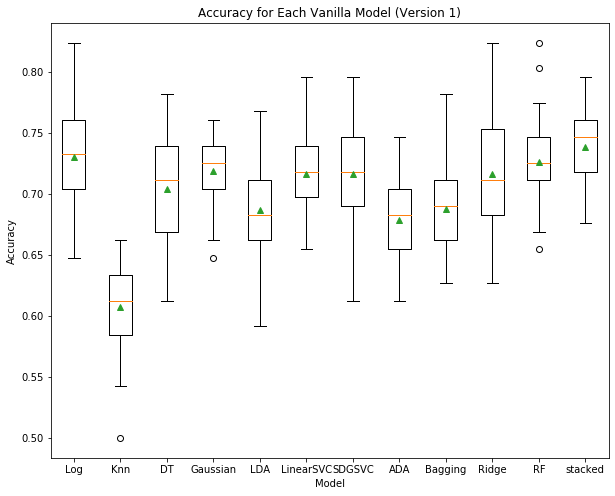

In [6]:
plt.figure(figsize = (10,8))
plt.boxplot(results, labels = model_names, showmeans = True)
plt.title('Accuracy for Each Vanilla Model (Version 1)')
plt.ylabel('Accuracy'); plt.xlabel('Model')
plt.savefig('figures/BaselineAccuracy.png')
plt.show()

In [7]:
models = {'Log': LogisticRegression(), 
          'Gaussian': GaussianNB(), 
          'LinearSVC': LinearSVC(max_iter = 1250, random_state = 10), 'SDGSVC': SGDClassifier(random_state = 10),  
          'Ridge': RidgeClassifier(random_state = 10), 'RF': RandomForestClassifier(random_state = 10)}

#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 3)
models['stacked'] = stack_model

#test each model and stacking
results = []
model_names = []
pbar = tqdm(models.items())
for model, m in pbar: 
    pbar.set_description(f'Evaluating {model.upper()}')
    cv = RepeatedStratifiedKFold(n_splits = 7, n_repeats = 7)
    scores = cross_val_score(m, x_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = 14, 
                             error_score = 'raise')
    results.append(scores)
    model_names.append(model)

Evaluating STACKED: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:55<00:00, 25.04s/it]


In [8]:
vanilla_dict = {i:y for i,y in zip(model_names, results)}
pickle.dump(vanilla_dict, open('models/VanillaResults2.p', 'wb'))

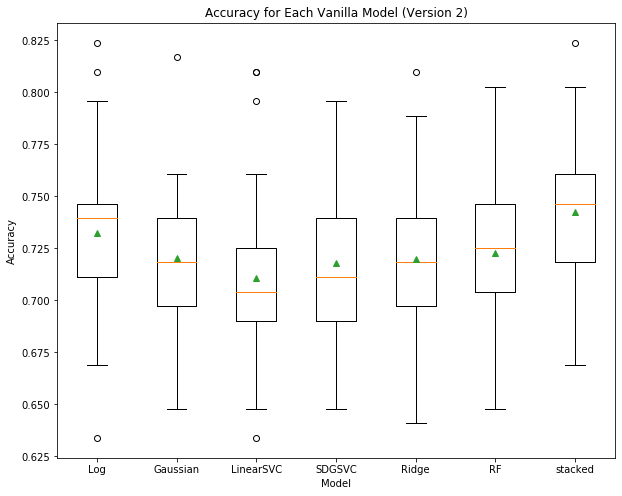

In [9]:
plt.figure(figsize = (10,8))
plt.boxplot(results, labels = model_names, showmeans = True)
plt.title('Accuracy for Each Vanilla Model (Version 2)')
plt.ylabel('Accuracy'); plt.xlabel('Model')
plt.savefig('figures/BaselineAccuracy2.png')
plt.show()

In [10]:
models = {'Log': LogisticRegression(), 
          'Gaussian': GaussianNB(), 
          'LinearSVC': LinearSVC(max_iter = 1250, random_state = 10), 'Ridge': RidgeClassifier(random_state = 10), 
          'RF': RandomForestClassifier(random_state = 10)}

#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 3)
models['stacked'] = stack_model

#test each model and stacking
results = []
model_names = []
pbar = tqdm(models.items())
for model, m in pbar: 
    pbar.set_description(f'Evaluating {model.upper()}')
    cv = RepeatedStratifiedKFold(n_splits = 7, n_repeats = 7)
    scores = cross_val_score(m, x_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = 14, 
                             error_score = 'raise')
    results.append(scores)
    model_names.append(model)

Evaluating STACKED: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:37<00:00, 26.20s/it]


In [11]:
vanilla_dict = {i:y for i,y in zip(model_names, results)}
pickle.dump(vanilla_dict, open('models/VanillaResults3.p', 'wb'))

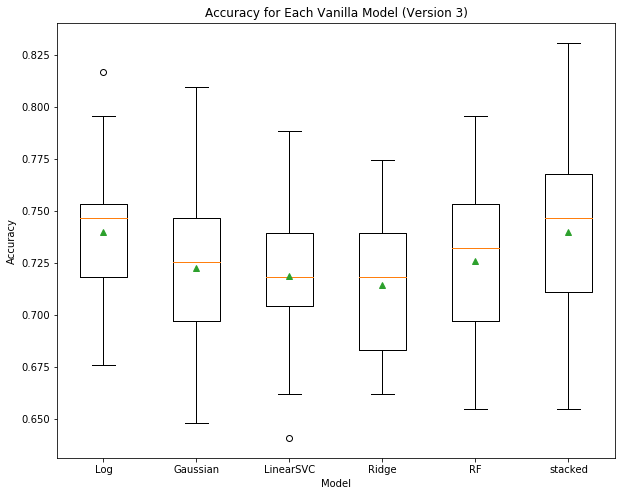

In [12]:
plt.figure(figsize = (10,8))
plt.boxplot(results, labels = model_names, showmeans = True)
plt.title('Accuracy for Each Vanilla Model (Version 3)')
plt.ylabel('Accuracy'); plt.xlabel('Model')
plt.savefig('figures/BaselineAccuracy2.png')
plt.show()

In [13]:
assert False

AssertionError: 

### Logistic Regression

In [15]:
vanilla_log = LogisticRegression()
vanilla_log.fit(x_train, y_train) 

print(f'Vanilla Train: {log.score(x_train, y_train)}')
print(f'Vanilla Test: {log.score(x_test, y_test)}')

Vanilla Train: 0.9859154929577465
Vanilla Test: 0.8181818181818182


In [ ]:

param_grid = { 
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'dual': [True, False],
    'tol': [1e-3, 1e-4, 1e-5],
    'C': [.5, 1],
    'intercept_scaling': [.5, 1, 1.5],
    'class_weight': ['balanced', None],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 1000],
    'l1_ratio': [None, .5],
}

log_cv = GridSearchCV(LogisticRegression(), param_grid, verbose = 2, n_jobs = 13)
log_cv.fit(x_train, y_train)

Fitting 5 folds for each of 5760 candidates, totalling 28800 fits


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:    1.4s
[Parallel(n_jobs=13)]: Done 168 tasks      | elapsed:    2.9s
[Parallel(n_jobs=13)]: Done 574 tasks      | elapsed:    6.4s
[Parallel(n_jobs=13)]: Done 1140 tasks      | elapsed:   11.8s
[Parallel(n_jobs=13)]: Done 1870 tasks      | elapsed:   18.8s
[Parallel(n_jobs=13)]: Done 2760 tasks      | elapsed:   26.8s
[Parallel(n_jobs=13)]: Done 3766 tasks      | elapsed:   53.2s
[Parallel(n_jobs=13)]: Done 4373 tasks      | elapsed:  4.5min
[Parallel(n_jobs=13)]: Done 5062 tasks      | elapsed:  8.6min
[Parallel(n_jobs=13)]: Done 5831 tasks      | elapsed: 13.2min
[Parallel(n_jobs=13)]: Done 6682 tasks      | elapsed: 19.2min
[Parallel(n_jobs=13)]: Done 7613 tasks      | elapsed: 22.5min
[Parallel(n_jobs=13)]: Done 8626 tasks      | elapsed: 22.8min
[Parallel(n_jobs=13)]: Done 9719 tasks      | elapsed: 23.2min
[Parallel(n_jobs=13)]: Done 11102 tasks     

In [ ]:
vectorizer = pickle.load(open('../Pickles/Vectorizer.p', 'rb'))

rand_sent = 'i love apple'

new_sent = vectorizer.transform([rand_sent]).toarray()

log.predict_proba(new_sent)